# Setup

In [39]:
import pandas as pd
import numpy as np


# Display all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


Load combined pre-processed datasets

In [40]:
train = pd.read_csv('../data/train_monthly.csv',sep='\t')
test = pd.read_csv('../data/test_monthly.csv',sep='\t')
val = pd.read_csv('../data/validation_monthly.csv',sep='\t')

# missing Nan value to 0 
#train['snow'] = train['snow'].fillna(0)
#train = train.dropna(subset=['snow'])


Check for Nan Values

In [41]:
train.isna().sum()

Unnamed: 0                                               0
date                                                     0
cdsd                                                     1
cldd                                                     0
dp01                                                     0
dp10                                                     0
dp1x                                                     0
dsnd                                                    24
dsnw                                                     0
dt00                                                     0
dt32                                                     0
dx32                                                     0
dx70                                                     0
dx90                                                     0
dyfg                                                   167
dynt                                                     0
dysd                                                    

In [42]:
train.describe()

Unnamed: 0        cdsd        cldd        dp01        dp10        dp1x  \
count   167.00000  166.000000  167.000000  167.000000  167.000000  167.000000   
mean     83.00000   12.846386    2.262275    6.185629    4.359281    0.616766   
std      48.35287   15.586605    6.451390    5.215388    4.220178    1.288207   
min       0.00000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      41.50000    0.000000    0.000000    2.000000    1.000000    0.000000   
50%      83.00000    2.450000    0.000000    5.000000    3.000000    0.000000   
75%     124.50000   29.000000    0.150000    9.000000    6.500000    1.000000   
max     166.00000   46.700000   40.500000   21.000000   19.000000    8.000000   

             dsnd        dsnw        dt00        dt32        dx32        dx70  \
count  143.000000  167.000000  167.000000  167.000000  167.000000  167.000000   
mean    11.069930    2.730539    0.071856   16.275449    1.161677    9.299401   
std     12.600945    3.611289    0.373342   12.236458    2.217992   12.038850   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    2.000000    0.000000    0.000000   
50%      4.000000    1.000000    0.000000   21.000000    0.000000    1.000000   
75%     25.000000    4.000000    0.000000   28.000000    1.000000   21.000000   
max     31.000000   18.000000    3.000000   31.000000   10.000000   31.000000   

             dx90  dyfg          dynt          dysd          dysn  dyts  \
count  167.000000   0.0  1.670000e+02  1.430000e+02  1.670000e+02   0.0   
mean     0.035928   NaN  2.007551e+07  2.006821e+07  2.007552e+07   NaN   
std      0.242780   NaN  4.050731e+04  3.913879e+04  4.050630e+04   NaN   
min      0.000000   NaN  2.001012e+07  2.001013e+07  2.001013e+07   NaN   
25%      0.000000   NaN  2.004066e+07  2.003567e+07  2.004067e+07   NaN   
50%      0.000000   NaN  2.007123e+07  2.006123e+07  2.007122e+07   NaN   
75%      0.000000   NaN  2.011066e+07  2.009117e+07  2.011067e+07   NaN   
max      2.000000   NaN  2.014123e+07  2.014122e+07  2.014122e+07   NaN   

               dyxp          dyxt        emnt         emsd        emsn  \
count  1.670000e+02  1.670000e+02  167.000000   143.000000  167.000000   
mean   2.007551e+07  2.007551e+07   -6.461677   339.244755  128.221557   
std    4.050649e+04  4.050703e+04    6.873905   452.926559  169.941712   
min    2.001011e+07  2.001010e+07  -20.000000     0.000000    0.000000   
25%    2.004067e+07  2.004067e+07  -12.200000     0.000000    0.000000   
50%    2.007121e+07  2.007120e+07   -6.700000    76.000000   51.000000   
75%    2.011066e+07  2.011068e+07   -1.100000   647.500000  229.000000   
max    2.014120e+07  2.014122e+07    6.100000  1880.000000  737.000000   

             emxp        emxt        evap         hdsd        htdd       mnpn  \
count  167.000000  167.000000   14.000000   160.000000  167.000000   3.000000   
mean    21.080838   20.927545  127.421429  1885.602500  338.413772  10.770000   
std     23.277115    7.414279   26.634049  1488.564259  193.900395   2.382939   
min      0.000000    8.300000   69.700000    12.300000   12.300000   8.090000   
25%      4.200000   13.900000  111.075000   286.550000  145.600000   9.830000   
50%     14.200000   21.700000  134.050000  1660.000000  377.800000  11.570000   
75%     27.550000   27.800000  146.825000  3348.625000  516.550000  12.110000   
max    136.400000   33.300000  159.800000  4366.000000  644.800000  12.650000   

            mxpn        prcp         snow        tavg        tmax        tmin  \
count   3.000000  167.000000   167.000000  167.000000  167.000000  167.000000   
mean   25.500000   60.256886   361.275449    7.014012   14.161677   -0.134551   
std     3.661857   76.428833   579.561640    6.730035    8.107926    5.404186   
min    22.020000    0.000000     0.000000   -2.810000    2.200000   -9.470000   
25%    23.590000    6.450000     0.000000    0.635000    6.390000   -

Check Snowfall data in Training data

In [43]:
train.loc[:,['date','snow']]

,date,snow
0,2001-01,661.0
1,2001-02,1589.0
2,2001-03,178.0
3,2001-04,580.0
4,2001-05,0.0
5,2001-06,0.0
6,2001-07,0.0
7,2001-08,0.0
8,2001-09,0.0
9,2001-10,0.0


So we have monthly data available from 2001 Jan to 2014 Dec. Now let's see Test data. 

In [44]:
test.loc[:,['date','snow']]

,date,snow
0,2019-01,1129.0
1,2019-02,3619.0
2,2019-03,458.0
3,2019-04,38.0
4,2019-05,241.0
5,2019-06,0.0
6,2019-07,0.0
7,2019-08,0.0
8,2019-09,51.0
9,2019-10,0.0


In [45]:
train.columns

Index(['Unnamed: 0', 'date', 'cdsd', 'cldd', 'dp01', 'dp10', 'dp1x', 'dsnd',
       'dsnw', 'dt00',
       ...
       'tc_loss_ha_Uruguay', 'tc_loss_ha_Uzbekistan', 'tc_loss_ha_Vanuatu',
       'tc_loss_ha_Venezuela', 'tc_loss_ha_Vietnam',
       'tc_loss_ha_Virgin Islands, U.S.', 'tc_loss_ha_Zambia',
       'tc_loss_ha_Zimbabwe', 'tc_loss_ha_Åland', 'tc_loss_ha_average'],
      dtype='object', length=1135)

In [46]:
features = ['tc_loss_ha_average','dp10','prcp']

X_train = train[features]
y_train = train[['snow']]


X_test = test[features]
y_test = test[['snow']]

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error



# Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [48]:
import matplotlib.pyplot as plt


# Predictions
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')



Mean Squared Error: 153794.04115809852


In [49]:
y_test

,snow
0,1129.0
1,3619.0
2,458.0
3,38.0
4,241.0
5,0.0
6,0.0
7,0.0
8,51.0
9,0.0


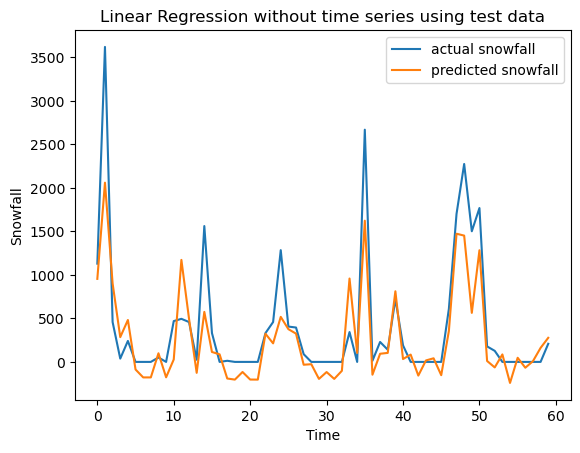

In [59]:
def plot_predictions(actual, predicted, xlabel, ylabel, title):
    plt.plot(actual,label='actual snowfall')
    plt.plot(predicted, label='predicted snowfall')

    plt.xlabel(xlabel)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()


plot_predictions(y_test, y_pred,"Time","Snowfall","Linear Regression without time series using test data")

In [51]:
# Convert data to sequences
def create_sequences(data, window_size, seq_features, target_variable):
    xs, ys = [], []
    for i in range(len(data) - window_size):
        x = data[i:i+window_size] [seq_features].values
        y = data[i+window_size:i+window_size+1][target_variable].values # pick 1 row after
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

window_size = 5
lstm_features = ['snow','prcp','dp10']
target_variable = 'snow'
X_seq_train, y_seq_train = create_sequences(train, window_size,lstm_features,target_variable)
X_seq_test, y_seq_test = create_sequences(test, window_size,lstm_features, target_variable)
X_seq_val, y_seq_val = create_sequences(val, window_size,lstm_features, target_variable)


X_seq_train.shape, y_seq_train.shape

((162, 5, 3), (162, 1))

Epoch 1/10
6/6 [==============================] - 1s 45ms/step - loss: 438088.5938 - accuracy: 0.0741 - val_loss: 553830.6250 - val_accuracy: 0.2558
Epoch 2/10
6/6 [==============================] - 0s 7ms/step - loss: 438823.9375 - accuracy: 0.1790 - val_loss: 533762.4375 - val_accuracy: 0.1395
Epoch 3/10
6/6 [==============================] - 0s 7ms/step - loss: 408507.2188 - accuracy: 0.1235 - val_loss: 520253.1250 - val_accuracy: 0.1163
Epoch 4/10
6/6 [==============================] - 0s 7ms/step - loss: 396345.4062 - accuracy: 0.1111 - val_loss: 510535.0625 - val_accuracy: 0.1395
Epoch 5/10
6/6 [==============================] - 0s 7ms/step - loss: 376519.3750 - accuracy: 0.1543 - val_loss: 515192.9375 - val_accuracy: 0.0698
Epoch 6/10
6/6 [==============================] - 0s 7ms/step - loss: 383099.3750 - accuracy: 0.0679 - val_loss: 520019.1562 - val_accuracy: 0.0698
Epoch 7/10
6/6 [==============================] - 0s 7ms/step - loss: 369098.2500 - accuracy: 0.0926 - val_loss

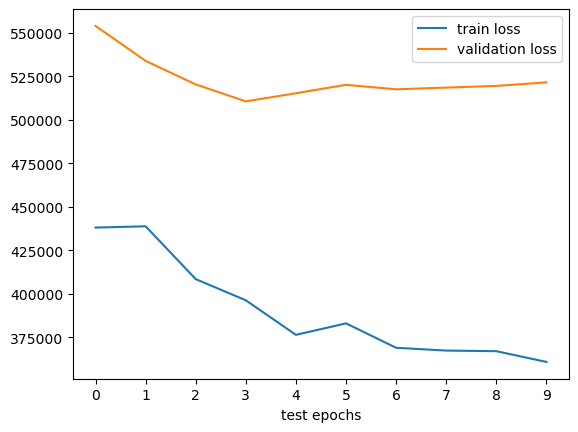

At last epoch, training loss: 360974.3750
At last epoch, Validation loss: 521432.4688
6/6 [==============================] - 0s 1ms/step


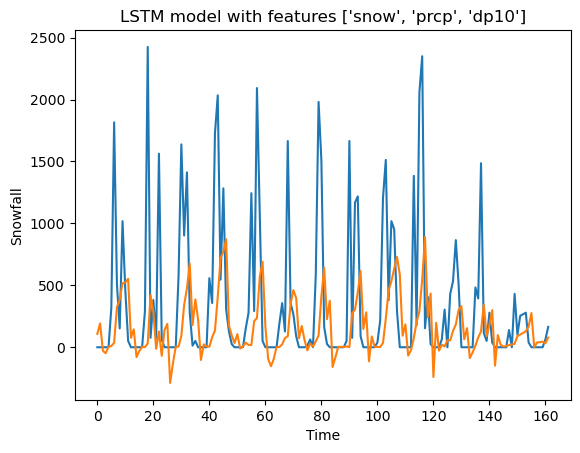

In [58]:
import tensorflow as tf
import tensorflow.keras as keras 

from tensorflow.keras.optimizers import Adam


def build_model(input_shape, hidden_layer_sizes, activation, learning_rate, metric):

    model = keras.Sequential() 

    #model.add(keras.layers.Flatten())
    model.add(keras.layers.LSTM(8, activation='relu', input_shape=input_shape))

    #model.add(keras.layers.Dense(10))

    for hidden_layer_size in hidden_layer_sizes:
        model.add(keras.layers.Dense(units=hidden_layer_size, activation=activation))

    # last layer is dense for regression output
    model.add(keras.layers.Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse', metrics=[metric])

    return model 


# Hyper parameters
num_epochs = 10
learning_rate = 0.01
metric = 'accuracy'

input_shape = (X_seq_train.shape[1], X_seq_train.shape[2])

# Build the model 
model1 = build_model(input_shape, [], activation='relu', learning_rate=learning_rate, metric=metric) 


# Train the model
history = model1.fit(X_seq_train, y_seq_train, epochs=num_epochs, validation_data=(X_seq_val, y_seq_val))

# Retrieve the testing metrics (after each test epoch) and the final validation
    # accuracy.
train_accuracy = history.history['loss']
val_accuracy = history.history['val_loss']
plt.plot(train_accuracy, label='train loss')
plt.plot(val_accuracy, label='validation loss')
plt.xticks(range(num_epochs))
plt.xlabel('test epochs')
plt.legend()
plt.show()

print('At last epoch, training loss: %1.4f' %train_accuracy[-1])
print('At last epoch, Validation loss: %1.4f' %val_accuracy[-1])


# Predictions from training data
y_pred_model1 = model1.predict(X_seq_train)
plot_predictions(y_seq_train, y_pred_model1,"Time","Snowfall","LSTM model with features {}".format(lstm_features))

